In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set(font_scale=0.7)

In [2]:
start = '2023-07-17T21:51:12.507+01:00'
end = '2023-07-17T22:04:40.866+01:00'

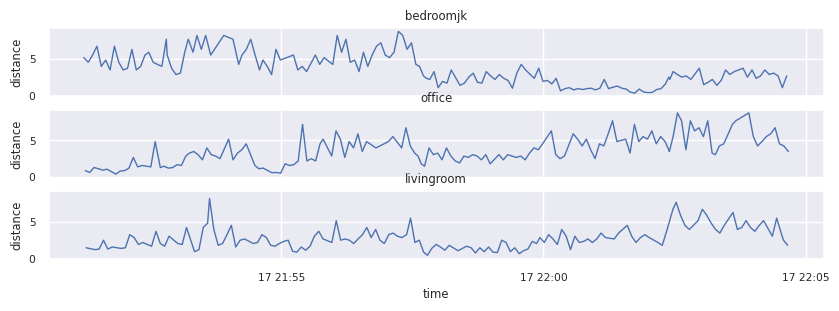

In [3]:
df = (
    pd.read_csv('data.csv', index_col=0, parse_dates=True)
    .rename(columns={'m.friendly_name_str': 'basestation', 'm.value': 'distance', 'state.state': 'room'})
    .replace({'basestation': {
        'MQTT iPhoneJD LivingRoom Raw': 'livingroom',
        'MQTT iPhoneJD Office Raw': 'office',
        'MQTT iPhoneJD BedroomJK Raw': 'bedroomjk'
    }})
    .dropna(subset=['basestation'])
    .loc[start:end]
)

fig, ax = plt.subplots(3, figsize=(10, 3), sharex=True, sharey=True)

for i, basestation in enumerate(df.basestation.unique()):
    sns.lineplot(df.loc[df.basestation == basestation, 'distance'], linewidth=1, ax=ax[i]).set_title(basestation)
plt.show()

In [4]:
df = (
    pd.read_csv('data.csv')
    .rename(columns={'m.friendly_name_str': 'basestation', 'm.value': 'distance', 'state.state': 'room'})
    .replace({'basestation': {
        'MQTT iPhoneJD LivingRoom Raw': 'livingroom',
        'MQTT iPhoneJD Office Raw': 'office',
        'MQTT iPhoneJD BedroomJK Raw': 'bedroomjk'
    }})
    .pivot(index=['time', 'room'], columns='basestation', values='distance')
    .reset_index('room')
    .fillna(method='ffill')
    .loc[start:end]
)
print(df.head())

X = df[['livingroom', 'office', 'bedroomjk']].values
y = df['room']

basestation                      room  NaN  bedroomjk  livingroom  office
time                                                                     
2023-07-17T21:51:12.507+01:00  Office  NaN       4.54        1.39    0.67
2023-07-17T21:51:14.278+01:00  Office  NaN       5.18        1.39    0.67
2023-07-17T21:51:15.874+01:00  Office  NaN       5.18        1.39    0.88
2023-07-17T21:51:16.718+01:00  Office  NaN       5.18        1.48    0.88
2023-07-17T21:51:19.291+01:00  Office  NaN       4.54        1.48    0.88


In [20]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define pipeline
pipeline = make_pipeline(
    PolynomialFeatures(degree=2),
    StandardScaler(),
    LogisticRegression(max_iter=100000)
)

# Use cross_val_score for StratifiedKFold cross-validation
scores = cross_val_score(pipeline, X, y, cv=StratifiedKFold(n_splits=5))

# Print metrics
print("Cross-validation accuracy scores:", scores)
print("Mean cross-validation accuracy:", scores.mean())

Cross-validation accuracy scores: [0.54166667 0.68421053 0.54736842 0.56842105 0.63157895]
Mean cross-validation accuracy: 0.5946491228070176


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Fit and score
pipeline.fit(X_train, y_train)
print(pipeline.score(X_test, y_test))

# Predict
y_pred = pipeline.predict(X_test)

# Print metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6470588235294118
[[ 6  0  2  0  0  0  3  0  0  0  0]
 [ 0 15  0  0  0  0  3  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0]
 [ 0  0  0  4  3  0  1  1  0  0  2]
 [ 0  0  0  0  4  0  0  0  1  6  1]
 [ 0  0  0  0  2  0  0  0  1  0  0]
 [ 0  8  1  1  0  0  3  0  1  0  0]
 [ 0  0  0  1  0  0  0  3  0  0  1]
 [ 0  1  0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  1  0  0  0  0  9  0]
 [ 0  0  0  1  0  0  0  0  0  0  8]]
              precision    recall  f1-score   support

   BedroomCC       1.00      0.55      0.71        11
   BedroomJK       0.62      0.83      0.71        18
    BedroomS       0.70      1.00      0.82         7
  DiningRoom       0.57      0.36      0.44        11
    Hallway0       0.40      0.33      0.36        12
    Hallway1       0.00      0.00      0.00         3
    Hallway2       0.30      0.21      0.25        14
     Kitchen       0.75      0.60      0.67         5
  LivingRoom       0.86      0.95      0.90        19
      Office       0.60      0.90      0.72

/home/justin/git/ESPresense-ml/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/justin/git/ESPresense-ml/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/justin/git/ESPresense-ml/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [26]:
pipeline.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=100000))])

In [27]:
import paho.mqtt.client as mqtt
import json

verbose = False

X_live = {
    'espresense/devices/jd_iphone/bedroomjk': 0.,
    'espresense/devices/jd_iphone/livingroom': 0.,
    'espresense/devices/jd_iphone/office': 0.,
}

def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    client.subscribe("espresense/devices/jd_iphone/bedroomjk")
    client.subscribe("espresense/devices/jd_iphone/office")
    client.subscribe("espresense/devices/jd_iphone/livingroom")

def on_message(client, userdata, msg):
    data = json.loads(msg.payload)
    if 'raw' in data:
        X_live[msg.topic] = data['raw']
        x = np.array(list(X_live.values())).reshape(1, -1)
        print(pipeline.predict(x))

client = mqtt.Client()
client.username_pw_set("mqtt-user", "vlmSDF543")
client.on_connect = on_connect
client.on_message = on_message
client.connect("192.168.50.134", 1883, 60)
client.loop_forever()

Connected with result code 0
['Office']
['LivingRoom']
['Hallway0']
['Hallway0']
['Hallway0']
['LivingRoom']
['LivingRoom']
['LivingRoom']
['LivingRoom']
['LivingRoom']
['LivingRoom']
['LivingRoom']
['LivingRoom']
['LivingRoom']
['LivingRoom']
['LivingRoom']
['LivingRoom']
['Hallway0']
['BedroomCC']
['BedroomCC']
['BedroomCC']
['BedroomCC']
['Hallway0']
['Hallway0']
['Hallway0']
['BedroomCC']
['BedroomCC']


KeyboardInterrupt: 